In [90]:
pip install tensorflow

In [91]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.


In [92]:
pip install keras

In [93]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

#Modeling
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import matplotlib.dates as mdates
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

#Evaluation
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

#### 1. Forecasting Saham ADRO

##### Model Prophet

In [7]:
# Load data
adro = pd.read_csv("Stock/ADRO.JK.csv")

# Tambah Kolom Kode Saham
adro['Kode'] = 'ADRO'

# Tampilkan Data
adro

,Date,Open,High,Low,Close,Adj Close,Volume,Kode
0,2008-08-01,1630.0,1680.0,1620.0,1630.0,625.735046,78478500.0,ADRO
1,2008-08-04,1590.0,1630.0,1590.0,1590.0,610.379700,43837000.0,ADRO
2,2008-08-05,1550.0,1580.0,1540.0,1550.0,595.024109,50244500.0,ADRO
3,2008-08-06,1540.0,1570.0,1540.0,1540.0,591.185242,48545500.0,ADRO
4,2008-08-07,1560.0,1570.0,1540.0,1560.0,598.863159,50999500.0,ADRO
...,...,...,...,...,...,...,...,...
3960,2024-08-29,3540.0,3590.0,3500.0,3520.0,3520.000000,63218700.0,ADRO
3961,2024-08-30,3540.0,3590.0,3510.0,3560.0,3560.000000,95767700.0,ADRO
3962,2024-09-02,3590.0,3650.0,3570.0,3610.0,3610.000000,96348100.0,ADRO
3963,2024-09-03,NaN,NaN,NaN,NaN,NaN,NaN,ADRO


In [8]:
# Handle Missing Values
adro = adro.dropna()

# mengecek missing values
adro.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Kode         0
dtype: int64

In [97]:
# mengubah tipe data kolom 'Date' menjadi datetime
adro['Date'] = pd.to_datetime(adro['Date'], format="%Y-%m-%d")

# mengecek informasi dataset
adro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3963 entries, 0 to 3964
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3963 non-null   datetime64[ns]
 1   Open       3963 non-null   float64       
 2   High       3963 non-null   float64       
 3   Low        3963 non-null   float64       
 4   Close      3963 non-null   float64       
 5   Adj Close  3963 non-null   float64       
 6   Volume     3963 non-null   float64       
 7   Kode       3963 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 278.6+ KB


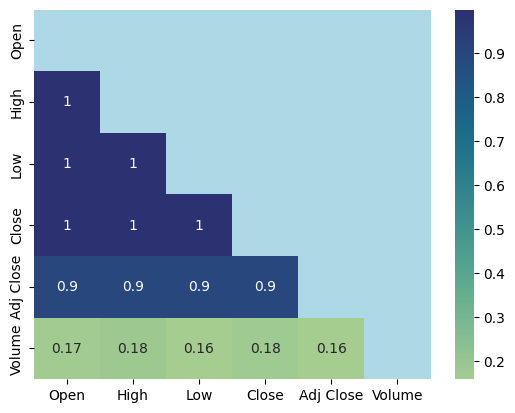

In [98]:
mask_adro = np.triu(np.ones_like(adro.corr(numeric_only=True))).astype(bool)
sns.heatmap(adro.corr(numeric_only=True), annot=True, mask=mask_adro, cmap='crest')
plt.show()

In [99]:
model = Prophet()

# Drop columns
model_df = adro.drop(['Open', 'High', 'Low', 'Volume', 'Kode', 'Adj Close'], axis=1)
model_df.rename(columns={'Close' : 'y', 'Date' : 'ds'}, inplace=True)

model_df

,ds,y
0,2008-08-01,1630.0
1,2008-08-04,1590.0
2,2008-08-05,1550.0
3,2008-08-06,1540.0
4,2008-08-07,1560.0
...,...,...
3959,2024-08-28,3530.0
3960,2024-08-29,3520.0
3961,2024-08-30,3560.0
3962,2024-09-02,3610.0


In [100]:
# Inisialisasi dan latih model dengan penyesuaian parameter
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality = 'auto'
)

# Latih model
model.fit(model_df)

18:27:36 - cmdstanpy - INFO - Chain [1] start processing
18:27:40 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
# Membuat tanggal prediksi
future_prices = model.make_future_dataframe(periods=365)

# prediksi harga
predict = model.predict(future_prices)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4323,2025-08-31,4007.575839,3499.476422,4510.222826
4324,2025-09-01,3890.267596,3361.726665,4427.216865
4325,2025-09-02,3896.846411,3400.969607,4427.314510
4326,2025-09-03,3904.432237,3384.155078,4428.325000
4327,2025-09-04,3911.554875,3396.325774,4428.813933


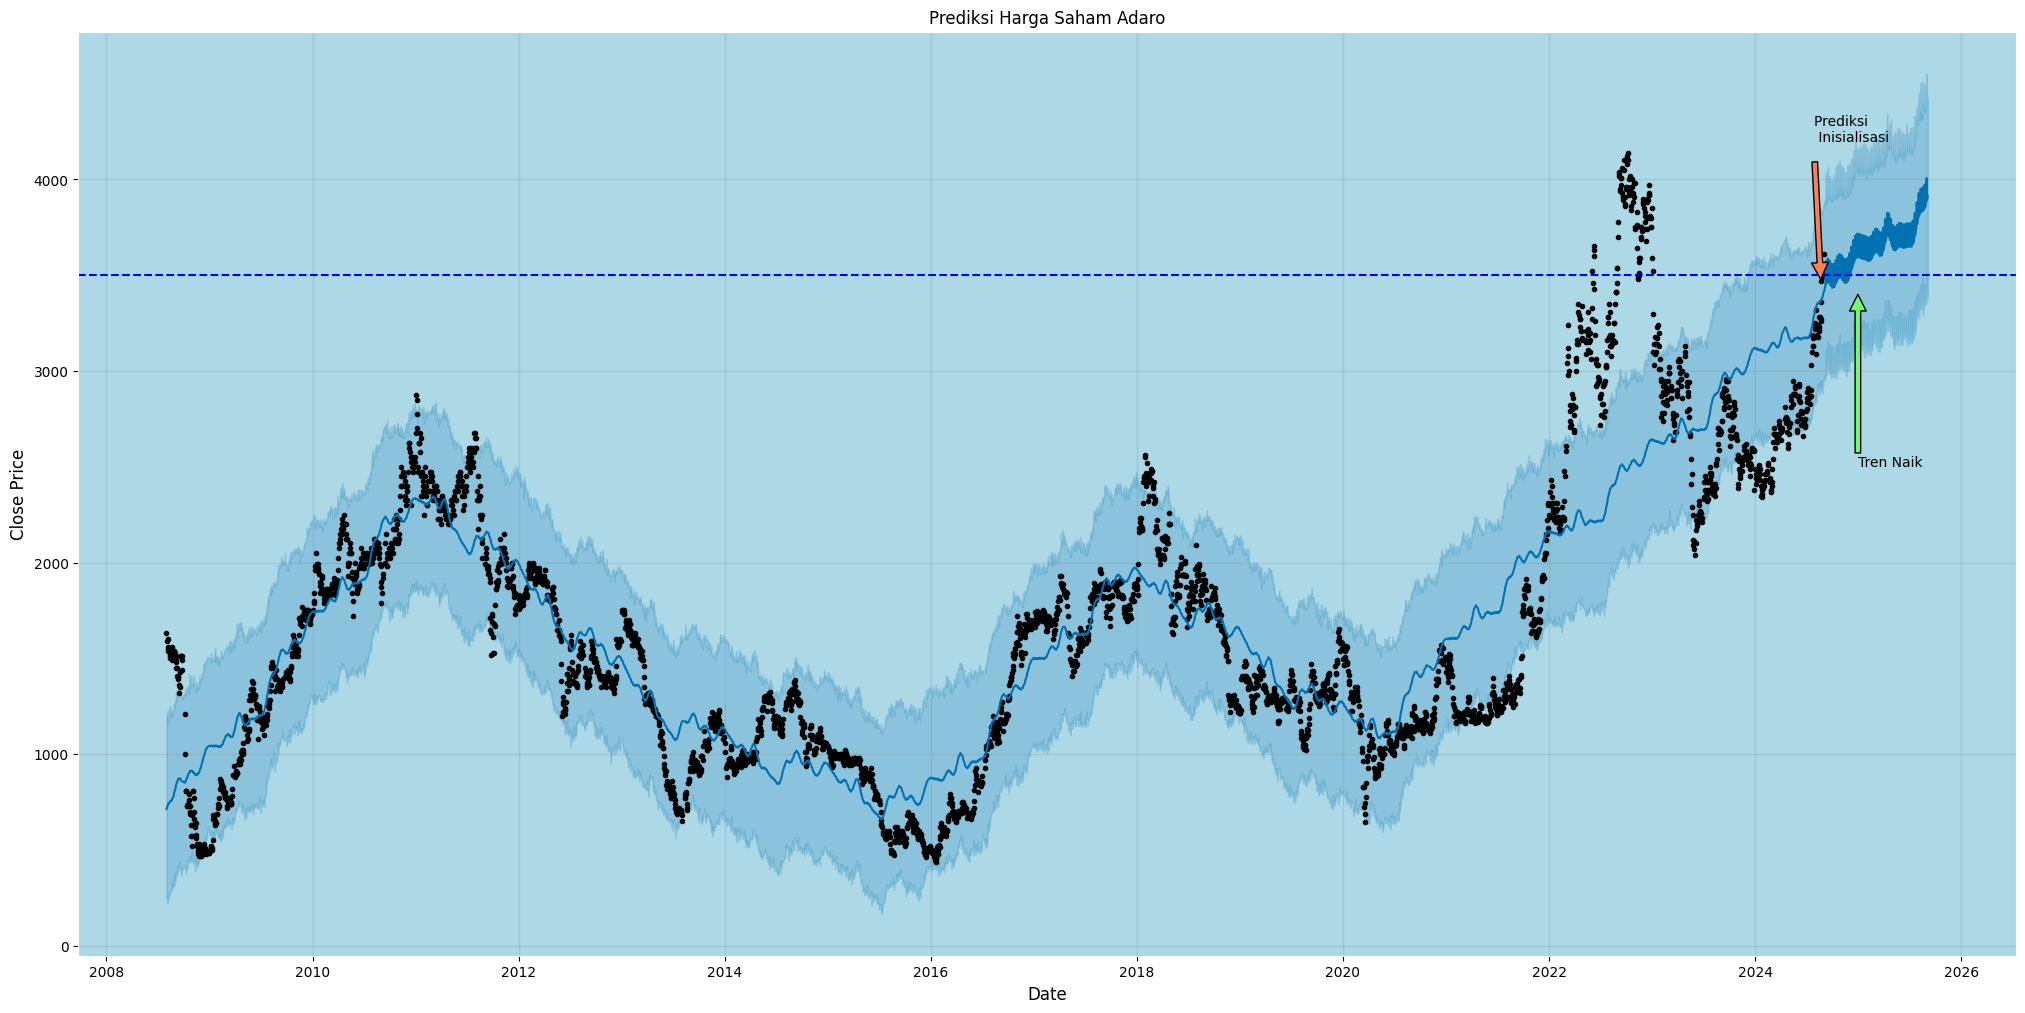

In [102]:
# Dates
start_date = dt.datetime(2024, 7, 27)
start_date1 = mdates.date2num(start_date)

trend_date = dt.datetime(2024, 12, 30)
trend_date1 = mdates.date2num(trend_date)

point_arrow = dt.datetime(2024, 8, 23)
point_arrow1 = mdates.date2num(point_arrow)

# plot
fig, ax1 = plt.subplots(figsize=(25, 12))
model.plot(predict, ax=ax1)
ax1.set_title('Prediksi Harga Saham Adaro')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price', fontsize=12)

# anotasi
ax1.annotate('Prediksi \n Inisialisasi', xy=(point_arrow1, 3400), xytext=(start_date1, 4200), 
             arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
             )
ax1.annotate('Tren Naik', xy=(trend_date1, 3400), xytext=(trend_date1, 2500), 
             arrowprops=dict(facecolor='#6cff6c', shrink=0.0),
             )

ax1.axhline(y=3500, color='b', linestyle='--')
plt.show()

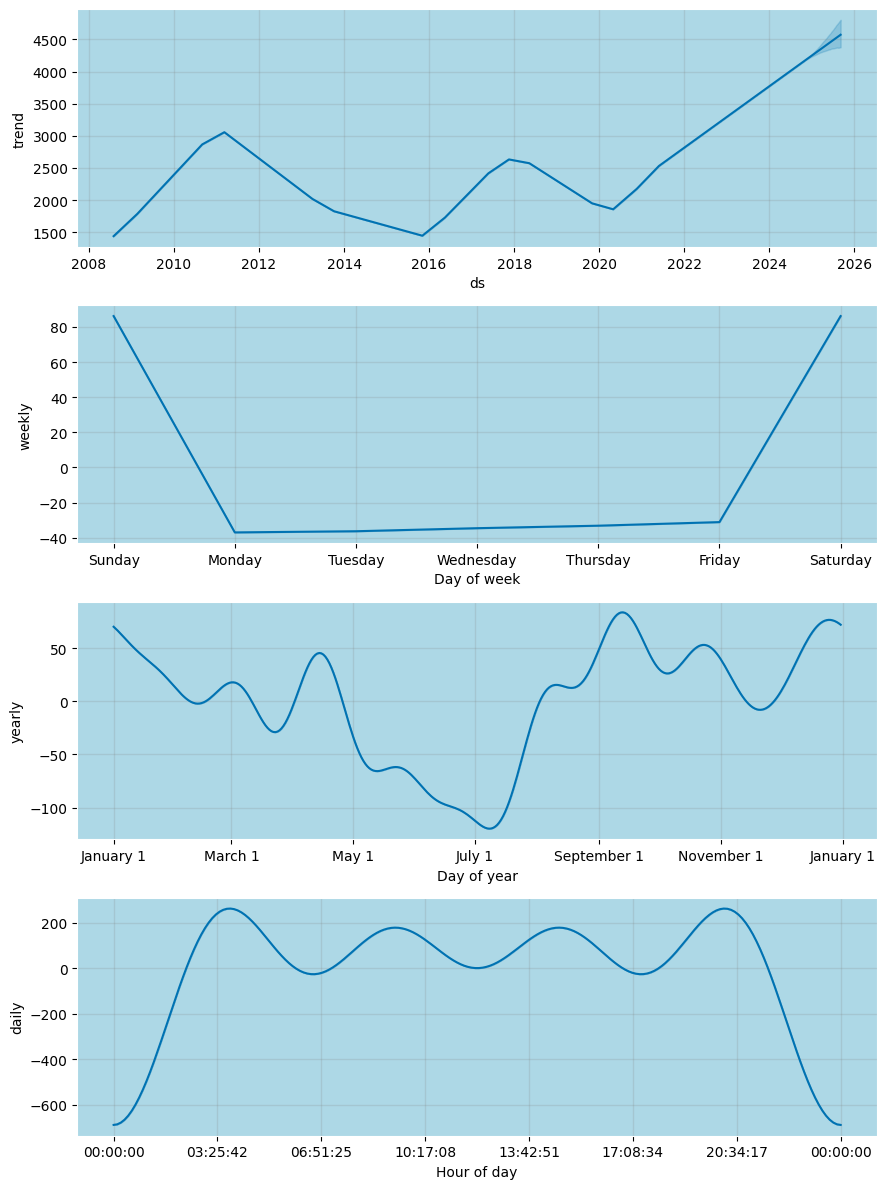

In [103]:
fig2 = model.plot_components(predict)
plt.show()

In [104]:
#Melakukan Crossvalidation dengan training data 5753 (>15 tahun), prediksi 180 (6 bulan) dan interval waktunya 120 (3 bulan)
cv_adro = cross_validation(model, initial='5753 days', period='180 days', horizon = '120 days')

  0%|          | 0/1 [00:00<?, ?it/s]

18:27:45 - cmdstanpy - INFO - Chain [1] start processing
18:27:48 - cmdstanpy - INFO - Chain [1] done processing


In [105]:
# Melihat hasil cross validation
cv_adro.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
74,2024-08-28,3539.223987,3091.527630,3964.502489,3530.0,2024-05-07
75,2024-08-29,3545.558882,3102.980924,4013.026371,3520.0,2024-05-07
76,2024-08-30,3552.059886,3074.731026,4044.566503,3560.0,2024-05-07
77,2024-09-02,3563.894003,3104.669426,4064.802843,3610.0,2024-05-07
78,2024-09-04,3579.275412,3123.900063,4045.921537,3560.0,2024-05-07


In [106]:
# Melihat performance metrics
pm_adro = performance_metrics(cv_adro)
pm_adro.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,13 days,172852.345209,415.755151,414.173805,0.143686,0.143864,0.133974,0.857143
1,14 days,176257.092057,419.829837,418.173596,0.145004,0.147866,0.135117,0.857143
2,15 days,183186.818904,428.003293,427.472177,0.148358,0.147866,0.138082,0.857143
3,20 days,188849.489947,434.568165,433.951118,0.150687,0.149563,0.140094,0.714286
4,21 days,215841.220096,464.587150,458.232785,0.160950,0.149563,0.148560,0.714286


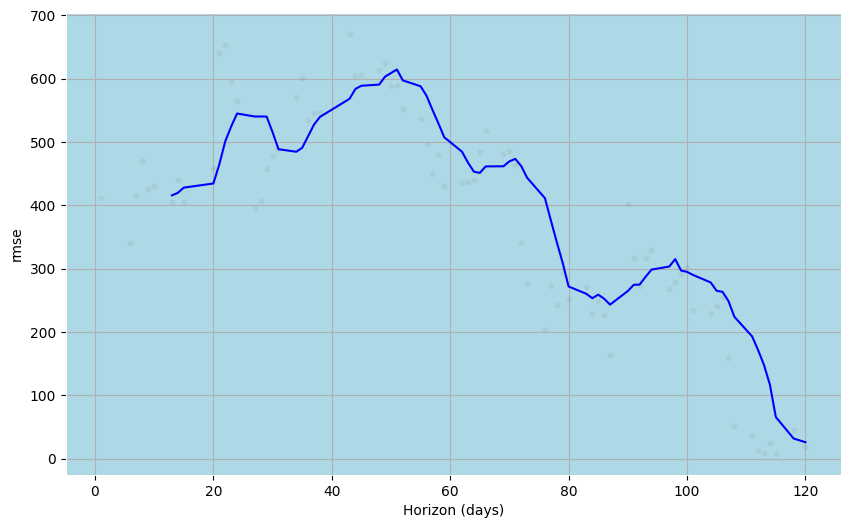

In [107]:
# Visualiasi RMSE
plot_cross_validation_metric(cv_adro, metric='rmse')
plt.show()

##### Model LSTM

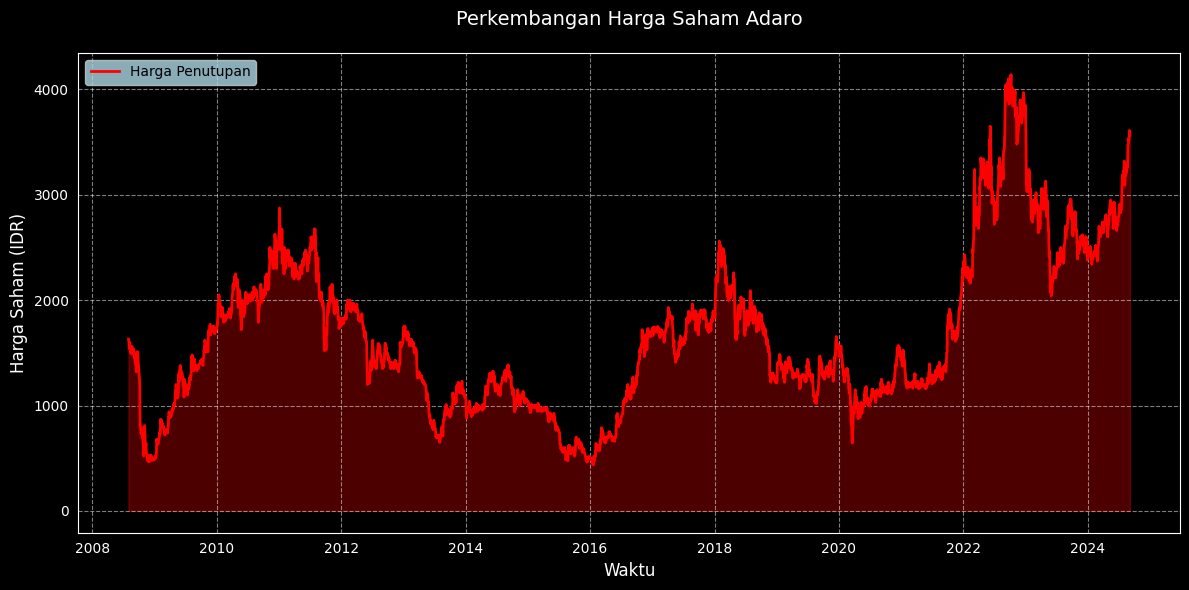

In [108]:
# Pastikan 'Date' dalam format datetime
adro['Date'] = pd.to_datetime(adro['Date'])

# Membuat grafik area
plt.figure(figsize=(12, 6))

# Menambahkan area untuk harga penutupan
plt.plot(adro['Date'], adro['Close'], color='red', linewidth=2, label='Harga Penutupan')
plt.fill_between(adro['Date'], adro['Close'], color='red', alpha=0.3)  # Mengisi area di bawah garis merah

# Mengatur layout plot
plt.title('Perkembangan Harga Saham Adaro', fontsize=14, color='white', pad=20)
plt.xlabel('Waktu', fontsize=12, color='white')
plt.ylabel('Harga Saham (IDR)', fontsize=12, color='white')

# Mengatur sumbu x dan y
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, color='white', linestyle='--', alpha=0.5)

# Mengatur background
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

# Menampilkan legend
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

In [109]:
# Create a new dataframe with only the 'Close' column 
data_adro = adro.filter(['Close'])

# Convert the dataframe to a numpy array
adro_df = data_adro.values

# Get the number of rows to train the model on (80% of the dataset)
training_data_len = int(np.ceil(len(adro_df)) * 0.80)

training_data_len

3170

In [110]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(adro_df)

scaled_data

array([[0.32217121],
       [0.31136916],
       [0.30056711],
       ...,
       [0.84337024],
       [0.85687281],
       [0.84337024]])

In [111]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.32217121, 0.31136916, 0.30056711, 0.29786659, 0.30326762,
       0.31406967, 0.29786659, 0.28976506, 0.28706454, 0.29246557,
       0.29516608, 0.28436403, 0.29516608, 0.29516608, 0.30326762,
       0.29786659, 0.29786659, 0.29516608, 0.29516608, 0.29786659,
       0.29516608, 0.28976506, 0.28166352, 0.28436403, 0.27356198,
       0.27356198, 0.26275992, 0.26275992, 0.26005941, 0.2573589 ,
       0.24925736, 0.23845531, 0.24655685, 0.26816095, 0.28976506,
       0.28976506, 0.28976506, 0.28976506, 0.28436403, 0.27086146,
       0.20874966, 0.15203889, 0.10072914, 0.10072914, 0.10072914,
       0.07912503, 0.07912503, 0.07912503, 0.08182555, 0.08182555,
       0.09532811, 0.08722657, 0.07912503, 0.06832298, 0.07102349,
       0.0521199 , 0.03591682, 0.02241426, 0.03591682, 0.06562247])]
[0.10072913853632191]

[array([0.32217121, 0.31136916, 0.30056711, 0.29786659, 0.30326762,
       0.31406967, 0.29786659, 0.28976506, 0.28706454, 0.29246557,
       0.29516608, 0.28436403, 0.29

In [112]:
!pip install tensorflow

In [113]:
!pip install tensorflow

In [114]:
pip install torch

In [115]:
pip show tensorflow


Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\Yoan Rifqi\Downloads\Project Analysis Personal\Dataset Saham Indonesia  Indonesia Stock Dataset\.venv\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [116]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.models import Model


In [117]:
test_size = adro[adro.Date.dt.year==2024].shape[0]
test_size

157

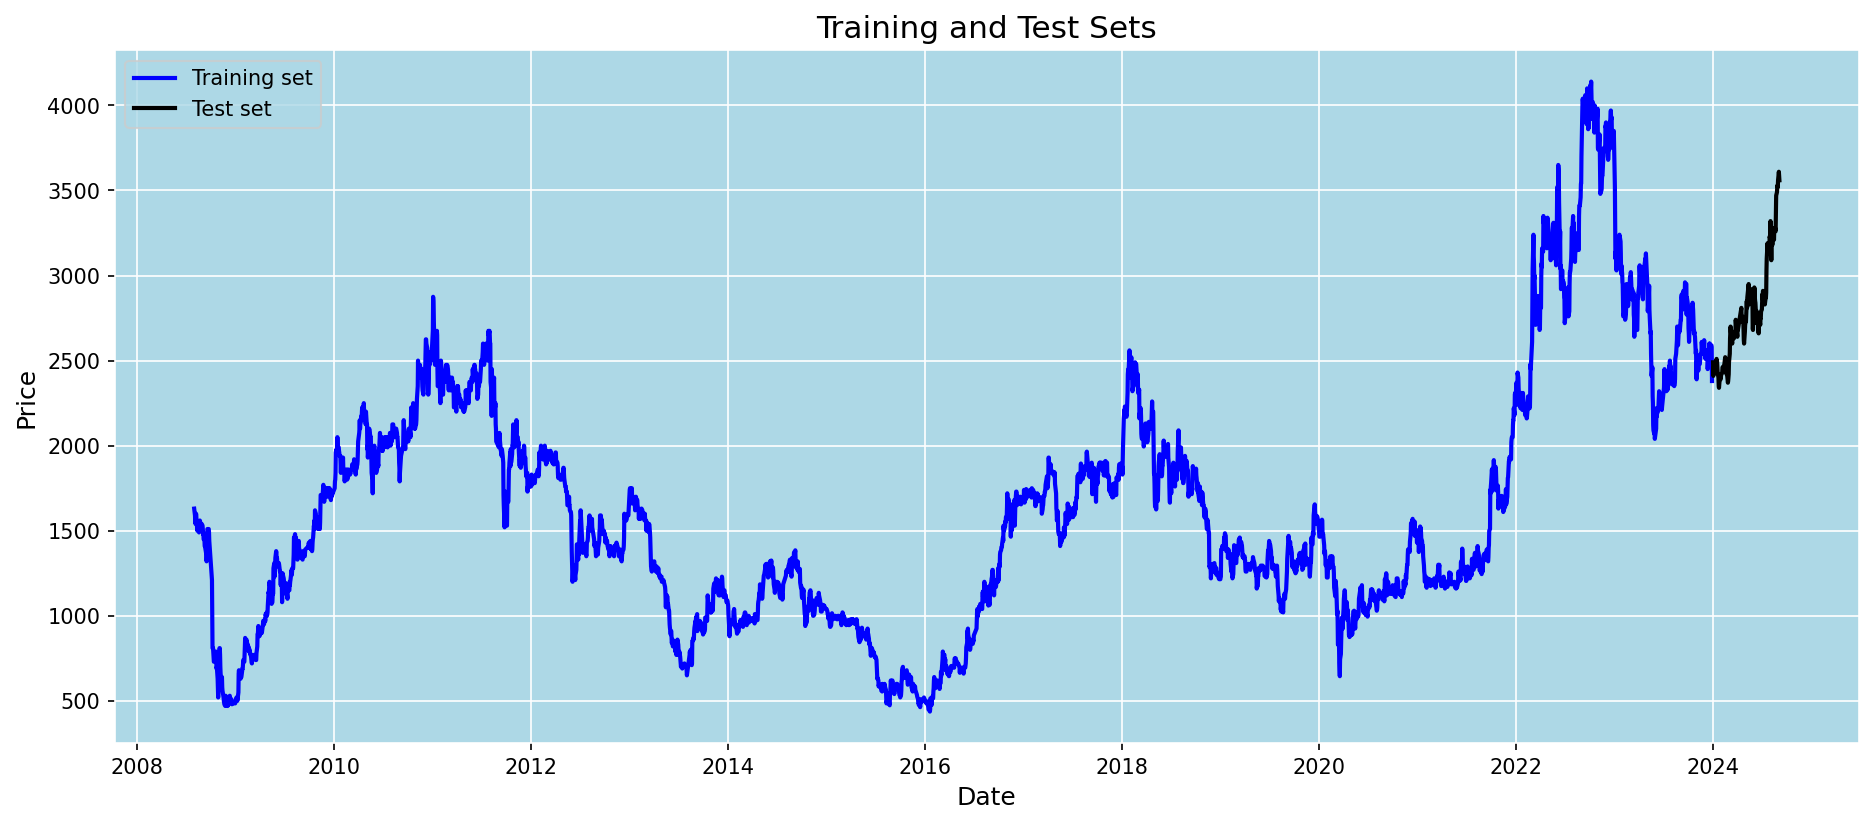

In [118]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(adro.Date[:-test_size], adro.Close[:-test_size], color='blue', lw=2)
plt.plot(adro.Date[-test_size:], adro.Close[-test_size:], color='black', lw=2)
plt.title('Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.grid(color='white')
plt.show()

In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(adro.Close.values.reshape(-1,1))

MinMaxScaler()

In [120]:
window_size = 365

In [121]:
train_data = adro.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [122]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-365:i, 0])
    y_train.append(train_data[i, 0])

In [123]:
test_data = adro.Close[-test_size-365:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [124]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-365:i, 0])
    y_test.append(test_data[i, 0])

In [125]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [126]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [127]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (3441, 365, 1)
y_train Shape:  (3441, 1)
X_test Shape:   (157, 365, 1)
y_test Shape:   (157, 1)


In [128]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [129]:
model = define_model()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 365, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 365, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 365, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 365, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 365, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 464ms/step - loss: 0.0441 - val_loss: 0.1463
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - loss: 0.0232 - val_loss: 0.1829
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - loss: 0.0226 - val_loss: 0.1794
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - loss: 0.0160 - val_loss: 0.0476
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 458ms/step - loss: 0.0020 - val_loss: 0.0299
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 466ms/step - loss: 0.0015 - val_loss: 0.0238
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 454ms/step - loss: 0.0012 - val_loss: 0.0176
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - loss: 0.0013 - val_loss: 0.0163
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 503ms/step - loss: 0.0010 - val_loss: 0.0171
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 471ms/step - loss: 9.8416e-04 - val_loss: 0.0203
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 467ms/step - loss: 9.0083e-04 - val_loss: 0.0167
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━

In [130]:
adro_result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 4.8365e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step


In [131]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [132]:
print("Test Loss: ", adro_result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss:  0.0007714193779975176
Test MAPE: 0.02923009148079385
Test Accuracy: 0.9707699085192062


In [133]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

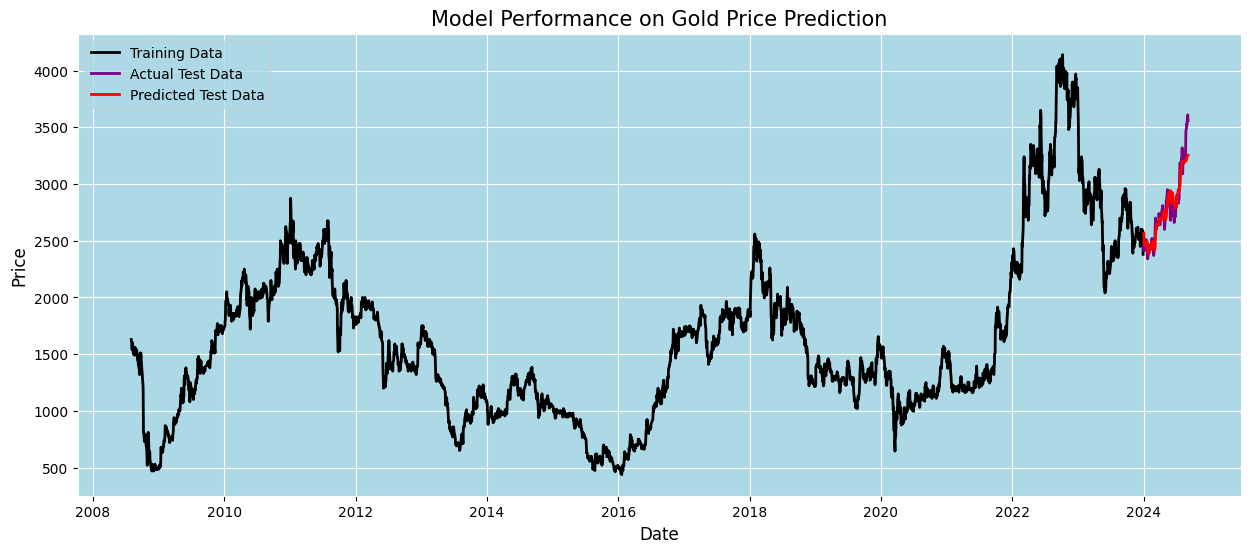

In [134]:
plt.figure(figsize=(15, 6))
plt.plot(adro['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(adro['Date'].iloc[-test_size:], y_test_true, color='purple', lw=2)
plt.plot(adro['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left')
plt.grid(color='white')
plt.show()

##### Model ARIMA

In [140]:
pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/614.7 kB ? eta -:--:--
   ---------------------------------------- 614.7/614.7 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [30]:
df_adro = pd.read_csv("Stock/ADRO.JK.csv")

In [31]:
# Konversi kolom 'Date' menjadi format datetime
df_adro['Date'] = pd.to_datetime(df_adro['Date'])

# Set kolom 'Date' sebagai index
df_adro.set_index('Date', inplace=True)

# Tampilkan Data
df_adro

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-08-01,1630.0,1680.0,1620.0,1630.0,625.735046,78478500.0
2008-08-04,1590.0,1630.0,1590.0,1590.0,610.379700,43837000.0
2008-08-05,1550.0,1580.0,1540.0,1550.0,595.024109,50244500.0
2008-08-06,1540.0,1570.0,1540.0,1540.0,591.185242,48545500.0
2008-08-07,1560.0,1570.0,1540.0,1560.0,598.863159,50999500.0
...,...,...,...,...,...,...
2024-08-29,3540.0,3590.0,3500.0,3520.0,3520.000000,63218700.0
2024-08-30,3540.0,3590.0,3510.0,3560.0,3560.000000,95767700.0
2024-09-02,3590.0,3650.0,3570.0,3610.0,3610.000000,96348100.0


In [37]:
df_adro = df_adro.dropna()

In [10]:
# !pip3 install pyramid-arima (already done)
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [38]:
target = df_adro['Close']

# Fit stepwise auto-ARIMA model with adjusted parameters
smodel = pm.auto_arima(target, start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=2, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

# Display model summary
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=10.05 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=51643.353, Time=0.36 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=43295.633, Time=13.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=48138.230, Time=13.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=51646.115, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=44367.900, Time=2.01 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=42865.194, Time=50.50 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=31.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=15.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=51645.608, Time=8.05 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=42866.677, Time=58.75 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=42866.727, Time=68.84 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=48140.213, Time=22.23 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=42866.090, Time=68.88 sec
 ARIMA(1,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3963
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood              -21418.044
Date:                             Tue, 17 Sep 2024   AIC                          42848.088
Time:                                     22:22:05   BIC                          42885.778
Sample:                                          0   HQIC                         42861.456
                                            - 3963                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9056      0.024     80.625      0.000       1.859       1.952
ar.L2         -0.9098      0.022    -40.483      0.000      -0.954      -0.866
ma.L1         -0.9213      0.027    -34.605      0.000      -0.973      -0.869
ar.S.L12      -0.6641      0.011    -59.541      0.000      -0.686      -0.642
ar.S.L24      -0.3263      0.011    -29.712      0.000      -0.348      -0.305
sigma2      2979.1333     37.505     79.434      0.000    2905.626    3052.641
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              3247.23
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=51643.353, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=43295.633, Time=11.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=48138.230, Time=10.73 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=51646.115, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=44367.900, Time=1.27 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=42865.194, Time=40.70 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=29.75 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=15.15 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=51645.608, Time=6.77 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=42866.677, Time=69.08 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=42866.727, Time=57.07 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=48140.213, Time=25.22 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=42866.090, Time=70.71 sec
 ARIMA(1,0,0)

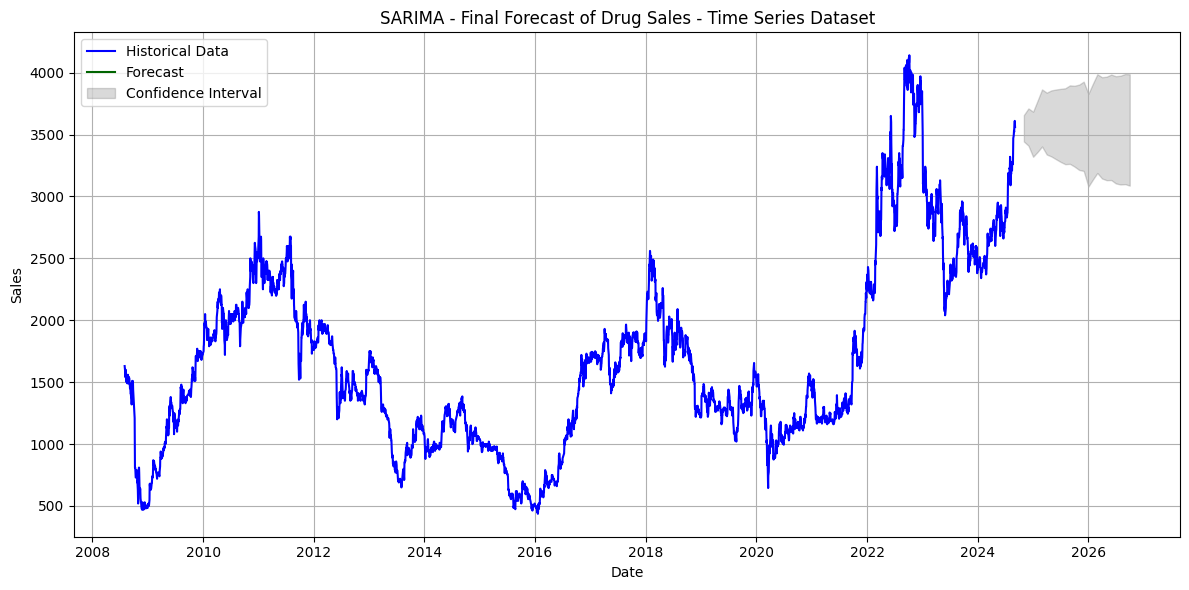

In [18]:
# Define target variable
target = adro['Close']

# Fit the auto-ARIMA model
smodel = pm.auto_arima(target, start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=2, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(start=adro.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

# Prepare series for plotting
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Debug outputs
print("Fitted Series:")
print(fitted_series.head())
print("\nLower Series:")
print(lower_series.head())
print("\nUpper Series:")
print(upper_series.head())

# Plot
plt.figure(figsize=(12, 6))  # Increase figure size for better visibility
plt.plot(adro.index, adro['Close'], label='Historical Data', color='blue')
plt.plot(fitted_series.index, fitted_series, color='darkgreen', label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15, label='Confidence Interval')

# Add titles and labels
plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)  # Add grid for better readability

# Show plot
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

In [59]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from itertools import product

from tqdm import tqdm_notebook


In [45]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary')
    else:
        print('Weak evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.')

In [46]:
adfuller_test(df_adro['Close'])

ADF Test Statistic: -1.2254943409659023
p-value: 0.6625336812561083
Weak evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.


In [47]:
df_adro1 = df_adro-df_adro.shift(1)

In [48]:
df_adro1 = df_adro1.dropna()

In [49]:
adfuller_test(df_adro1['Close'])

ADF Test Statistic: -43.26049420355983
p-value: 0.0
Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary


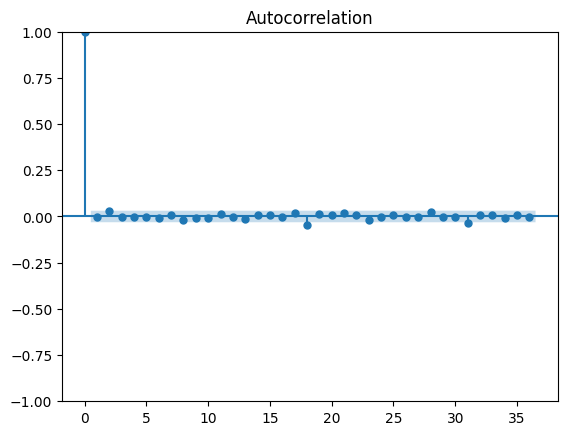

In [52]:
plot_acf(df_adro1['Close']);

In [56]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [57]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [60]:
result_df = optimize_ARIMA(df_adro['Close'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(4, 1, 5)",41877.563533
1,"(4, 1, 4)",41877.587197
2,"(5, 1, 4)",41877.957500
3,"(5, 1, 5)",41879.963537
4,"(6, 1, 3)",41880.199760
...,...,...
58,"(6, 1, 4)",41896.850279
59,"(5, 1, 7)",41898.455430
60,"(4, 1, 7)",41898.467475
61,"(7, 1, 4)",41898.892754


In [61]:
best_model = SARIMAX(df_adro['Close'], seasonal_order=(6,1,4,30), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

#### 2. Forecasting Saham BUMI

#### 3. Forecasting Saham BYAN

#### 4. Forecasting Saham GEMS

#### 5. Forecasting Saham INDY

#### 6. Forecasting Saham ITMG

#### 7. Forecasting Saham PTBA